In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.8 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

In [6]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [7]:
len(df)

26709

In [8]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [9]:
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [10]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [11]:
import string
string.punctuation

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df['headline']= df['headline'].apply(lambda x:remove_punctuation(str(x)))

In [12]:
df['headline']= df['headline'].apply(lambda x: x.lower())

In [13]:
stop = nltk.corpus.stopwords.words('english')
df['headline']= df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [14]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['former', 'versace', 'store', 'clerk', 'sues']

In [15]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'new': 1516,
 'trump': 1257,
 'man': 1250,
 'us': 567,
 'report': 514,
 'one': 514,
 'area': 484,
 'donald': 471,
 'says': 453,
 'woman': 442}

In [16]:
X = df['headline']
y = df['is_sarcastic'].astype(int)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)

In [18]:
from tokenizers import BertWordPieceTokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [19]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [20]:
x_train = fast_encode(X_train.values, fast_tokenizer, 400)
x_test = fast_encode(X_test.values, fast_tokenizer, 400)

In [21]:
x_train

array([[  101,  7207, 13239, ...,     0,     0,     0],
       [  101,  5987,  4630, ...,     0,     0,     0],
       [  101,  3113, 15302, ...,     0,     0,     0],
       ...,
       [  101,  3842,  7670, ...,     0,     0,     0],
       [  101,  6950,  2360, ...,     0,     0,     0],
       [  101,  6875, 10707, ...,     0,     0,     0]])

In [22]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [24]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 400)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 400,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

In [25]:
history = model.fit(x_train,y_train,batch_size = 16 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3
1252/1252 [==============================] - 1023s 798ms/step - loss: 0.7180 - accuracy: 0.5352 - val_loss: 0.6868 - val_accuracy: 0.5611
Epoch 2/3
1252/1252 [==============================] - 1001s 800ms/step - loss: 0.6894 - accuracy: 0.5551 - val_loss: 0.6861 - val_accuracy: 0.5611
Epoch 3/3
1252/1252 [==============================] - 1002s 801ms/step - loss: 0.6873 - accuracy: 0.5589 - val_loss: 0.6864 - val_accuracy: 0.5611


In [26]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

209/209 [==============================] - 93s 444ms/step - loss: 0.6864 - accuracy: 0.5611
Accuracy of the model on Testing Data is -  56.10961318016052 %


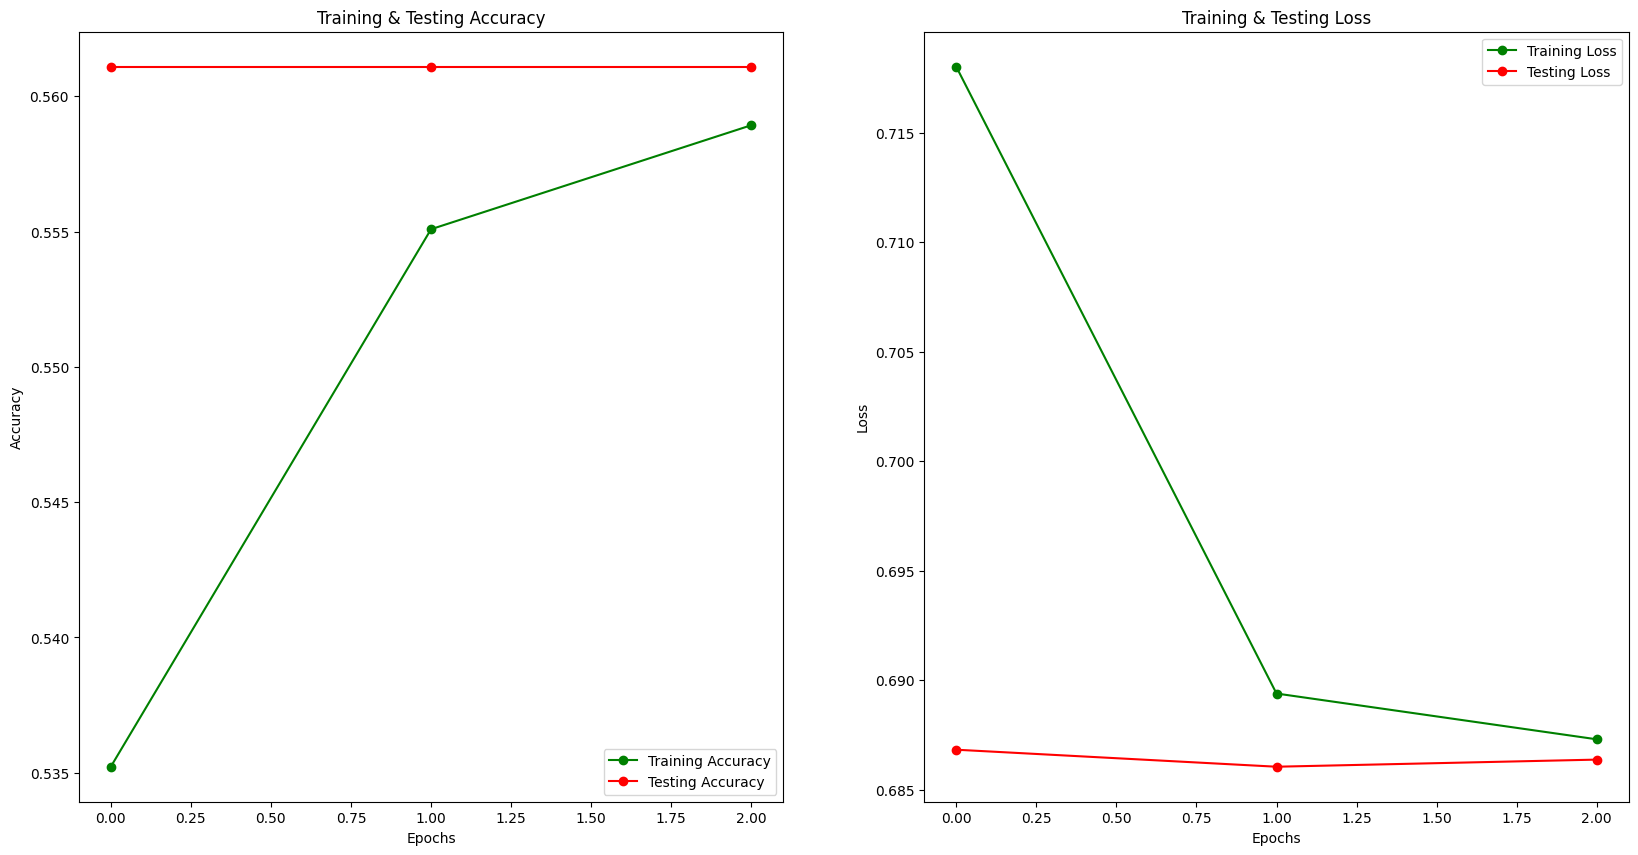

In [27]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [28]:
pred = model.predict(x_test)
pred[:5]

209/209 [==============================] - 94s 441ms/step


array([[0.42023215],
       [0.42023215],
       [0.42023215],
       [0.42023215],
       [0.42023215]], dtype=float32)

In [29]:
pred = np.round(pred).astype(int)
pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [30]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.56      1.00      0.72      3747
           1       0.00      0.00      0.00      2931

    accuracy                           0.56      6678
   macro avg       0.28      0.50      0.36      6678
weighted avg       0.31      0.56      0.40      6678



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
cm = confusion_matrix(y_test,pred)
cm

array([[3747,    0],
       [2931,    0]])

Text(95.72222222222221, 0.5, 'Actual')

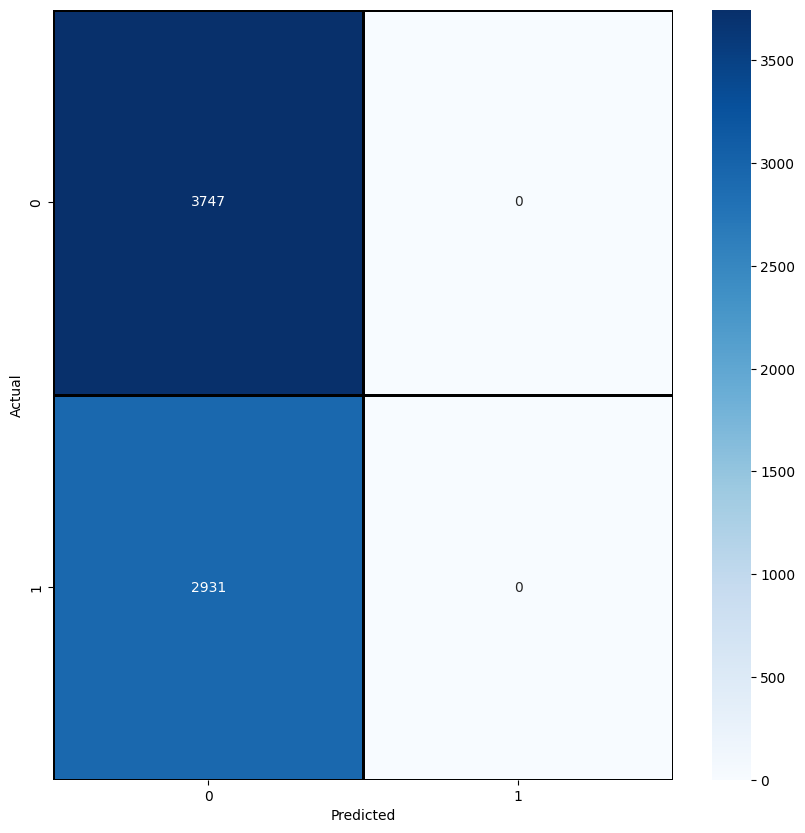

In [32]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")